<a href="https://colab.research.google.com/github/mahmoodtt1/OR/blob/main/Signal_Coordination_7_17_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyomo.environ import *

# install needed libraries

!pip install networkx matplotlib

# install pyomo solvers.

!apt-get install -y glpk-utils

!apt-get install -y coinor-cbc


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 35 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

In [2]:
from pyomo.environ import *

# Create model
model = ConcreteModel()

# Sets
model.I = Set(initialize=['1'])  # single coordinated phase for now

# Parameters
C = 120
t_AB = 65
g_min = 15
g_max = 60
M = 1000  # Large constant for Big-M

model.C = Param(initialize=C)
model.t_AB = Param(initialize=t_AB)
model.g_min = Param(initialize=g_min)
model.g_max = Param(initialize=g_max)
model.M = Param(initialize=M)

# Variables
model.s_A = Var(model.I, bounds=(0, C))                     # start at A
model.s_B = Var(model.I, bounds=(0, C))                     # start at B
model.g_A = Var(model.I, bounds=(g_min, g_max))             # green time at A
model.g_B = Var(model.I, bounds=(g_min, g_max))             # green time at B

model.e_A = Var(model.I)                                    # end time at A
model.e_B = Var(model.I)                                    # end time at B

model.early_end = Var(model.I)                              # min(e_A, e_B - t_AB)
model.late_start = Var(model.I)                             # max(s_A, s_B - t_AB)
model.o = Var(model.I, within=NonNegativeReals)             # overlap duration

model.x = Var(model.I, within=Binary)                       # for min()
model.y = Var(model.I, within=Binary)                       # for max()

# Constraints

# End time definitions
def end_A_rule(m, i):
    return m.e_A[i] == m.s_A[i] + m.g_A[i]
model.end_A = Constraint(model.I, rule=end_A_rule)

def end_B_rule(m, i):
    return m.e_B[i] == m.s_B[i] + m.g_B[i]
model.end_B = Constraint(model.I, rule=end_B_rule)

# Shifted values (in constraints directly, so no extra variables)

# Min(e_A, e_B - t_AB) using binary x
def min_upper_1(m, i):
    return m.early_end[i] <= m.e_A[i]
def min_upper_2(m, i):
    return m.early_end[i] <= m.e_B[i] - m.t_AB
def min_lower_1(m, i):
    return m.early_end[i] >= m.e_A[i] - m.M * (1 - m.x[i])
def min_lower_2(m, i):
    return m.early_end[i] >= m.e_B[i] - m.t_AB - m.M * m.x[i]

model.min1_u1 = Constraint(model.I, rule=min_upper_1)
model.min1_u2 = Constraint(model.I, rule=min_upper_2)
model.min1_l1 = Constraint(model.I, rule=min_lower_1)
model.min1_l2 = Constraint(model.I, rule=min_lower_2)

# Max(s_A, s_B - t_AB) using binary y
def max_lower_1(m, i):
    return m.late_start[i] >= m.s_A[i]
def max_lower_2(m, i):
    return m.late_start[i] >= m.s_B[i] - m.t_AB
def max_upper_1(m, i):
    return m.late_start[i] <= m.s_A[i] + m.M * (1 - m.y[i])
def max_upper_2(m, i):
    return m.late_start[i] <= m.s_B[i] - m.t_AB + m.M * m.y[i]

model.max1_l1 = Constraint(model.I, rule=max_lower_1)
model.max1_l2 = Constraint(model.I, rule=max_lower_2)
model.max1_u1 = Constraint(model.I, rule=max_upper_1)
model.max1_u2 = Constraint(model.I, rule=max_upper_2)

# Overlap definition
def overlap_rule(m, i):
    return m.o[i] == m.early_end[i] - m.late_start[i]
model.overlap_def = Constraint(model.I, rule=overlap_rule)

# Ensure non-negative overlap
def overlap_nonneg(m, i):
    return m.o[i] >= 0
model.overlap_nonneg = Constraint(model.I, rule=overlap_nonneg)

# Objective: maximize total overlap
def objective_rule(m):
    return sum(m.o[i] for i in m.I)
model.obj = Objective(rule=objective_rule, sense=maximize)


In [3]:
solver = SolverFactory("glpk", executable="/usr/bin/glpsol")

results = solver.solve(model, tee=True)



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpbd_s4u7h.glpk.raw --wglp /tmp/tmp635zfort.glpk.glp --cpxlp
 /tmp/tmphyto7cbp.pyomo.lp
Reading problem data from '/tmp/tmphyto7cbp.pyomo.lp'...
/tmp/tmphyto7cbp.pyomo.lp:88: warning: lower bound of variable 'x15' redefined
/tmp/tmphyto7cbp.pyomo.lp:88: warning: upper bound of variable 'x15' redefined
12 rows, 11 columns, 30 non-zeros
2 integer variables, all of which are binary
90 lines were read
Writing problem data to '/tmp/tmp635zfort.glpk.glp'...
75 lines were written
GLPK Integer Optimizer 5.0
12 rows, 11 columns, 30 non-zeros
2 integer variables, all of which are binary
Preprocessing...
4 constraint coefficient(s) were reduced
11 rows, 8 columns, 26 non-zeros
2 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.800e+02  ratio =  1.800e+02
GM: min|aij| =  8.940e-01  max|aij| =  1.119e+00  ratio =  1.251e+00
EQ: min|aij| =  7.993e-01  max|aij| =  1.

In [4]:

for i in model.I:
    print(f"Phase {i}:")
    print(f"  s_A = {value(model.s_A[i]):.2f}")
    print(f"  g_A = {value(model.g_A[i]):.2f}")
    print(f"  s_B = {value(model.s_B[i]):.2f}")
    print(f"  g_B = {value(model.g_B[i]):.2f}")
    print(f"  Overlap = {value(model.o[i]):.2f}")


Phase 1:
  s_A = 0.00
  g_A = 60.00
  s_B = 65.00
  g_B = 60.00
  Overlap = 60.00


In [5]:
from pyomo.environ import *

def build_corridor_overlap_model(n_signals, cycle_time, travel_times, g_min, g_max, M=1000):
    model = ConcreteModel()

    # Sets
    model.J = RangeSet(1, n_signals)

    # Parameters
    model.C = Param(initialize=cycle_time)
    model.t = Param(model.J, initialize=travel_times)
    model.g_min = Param(initialize=g_min)
    model.g_max = Param(initialize=g_max)
    model.M = Param(initialize=M)

    # Variables
    model.s = Var(model.J, bounds=(0, cycle_time))           # green start
    model.g = Var(model.J, bounds=(g_min, g_max))            # green duration
    model.e = Var(model.J)                                   # green end
    model.x = Var(model.J, within=Binary)                    # for early_end (min)
    model.y = Var(model.J, within=Binary)                    # for late_start (max)

    model.early_end = Var()                                  # min(e_j - t_j)
    model.late_start = Var()                                 # max(s_j - t_j)
    model.o = Var(within=NonNegativeReals)                   # overlap

    # Constraints
    def end_def(m, j):
        return m.e[j] == m.s[j] + m.g[j]
    model.end_def = Constraint(model.J, rule=end_def)

    # Min (early_end)
    def early_upper(m, j):
        return m.early_end <= m.e[j] - m.t[j]
    def early_lower(m, j):
        return m.early_end >= m.e[j] - m.t[j] - m.M * m.x[j]
    model.early_upper = Constraint(model.J, rule=early_upper)
    model.early_lower = Constraint(model.J, rule=early_lower)

    # Max (late_start)
    def late_lower(m, j):
        return m.late_start >= m.s[j] - m.t[j]
    def late_upper(m, j):
        return m.late_start <= m.s[j] - m.t[j] + m.M * m.y[j]
    model.late_lower = Constraint(model.J, rule=late_lower)
    model.late_upper = Constraint(model.J, rule=late_upper)

    # Min/max selector constraints
    model.min_selector = Constraint(expr=sum(model.x[j] for j in model.J) == n_signals - 1)
    model.max_selector = Constraint(expr=sum(model.y[j] for j in model.J) == n_signals - 1)

    # Overlap definition
    model.overlap_def = Constraint(expr=model.o == model.early_end - model.late_start)
    model.overlap_nonneg = Constraint(expr=model.o >= 0)

    # Objective
    model.obj = Objective(expr=model.o, sense=maximize)

    return model


In [6]:
import random
from pyomo.environ import SolverFactory, value

# Parameters
n = 5                              # Number of signals
C = 120                             # Cycle time in seconds
g_min = 25
g_max = 46

# Random cumulative travel times (monotonically increasing)
distances = sorted(random.randint(150, 500) for _ in range(n))
speeds = [random.uniform(10, 15) for _ in range(n)]  # m/s
t = {j + 1: distances[j] / speeds[j] for j in range(n)}  # seconds

# Build and solve model
model = build_corridor_overlap_model(n_signals=n, cycle_time=C, travel_times=t, g_min=g_min, g_max=g_max)

solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
results = solver.solve(model, tee=False)

# Print results
print(f"\n🟢 Max corridor green-band overlap: {value(model.o):.2f} seconds\n")
for j in model.J:
    print(f"Signal {j}: Start = {value(model.s[j]):.2f}, Green = {value(model.g[j]):.2f}, Travel Time = {t[j]:.2f}")



🟢 Max corridor green-band overlap: 46.00 seconds

Signal 1: Start = 1.27, Green = 46.00, Travel Time = 15.25
Signal 2: Start = 0.00, Green = 46.00, Travel Time = 13.99
Signal 3: Start = 1.38, Green = 46.00, Travel Time = 15.37
Signal 4: Start = 0.88, Green = 46.00, Travel Time = 14.86
Signal 5: Start = 2.65, Green = 46.00, Travel Time = 16.64


In [7]:
import matplotlib.pyplot as plt

def plot_green_bands(model, travel_times):
    fig, ax = plt.subplots(figsize=(10, 6))

    for j in model.J:
        s = value(model.s[j])
        g = value(model.g[j])
        t = travel_times[j]
        start_shifted = s - t
        end_shifted = start_shifted + g

        # Draw green bar
        ax.broken_barh([(start_shifted, g)], (j - 0.4, 0.8), facecolors='green')

        # Annotate
        ax.text(start_shifted + g / 2, j, f"{g:.1f}s", va='center', ha='center', color='white', fontsize=8)

    # Format axes
    ax.set_xlabel("Time (shifted to signal 1 reference) [s]")
    ax.set_ylabel("Signal Index")
    ax.set_title("🟢 Green Band Visualization")
    ax.set_yticks(list(model.J))
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    ax.set_ylim(0.5, len(model.J) + 0.5)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-7-1522795884.py:26: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


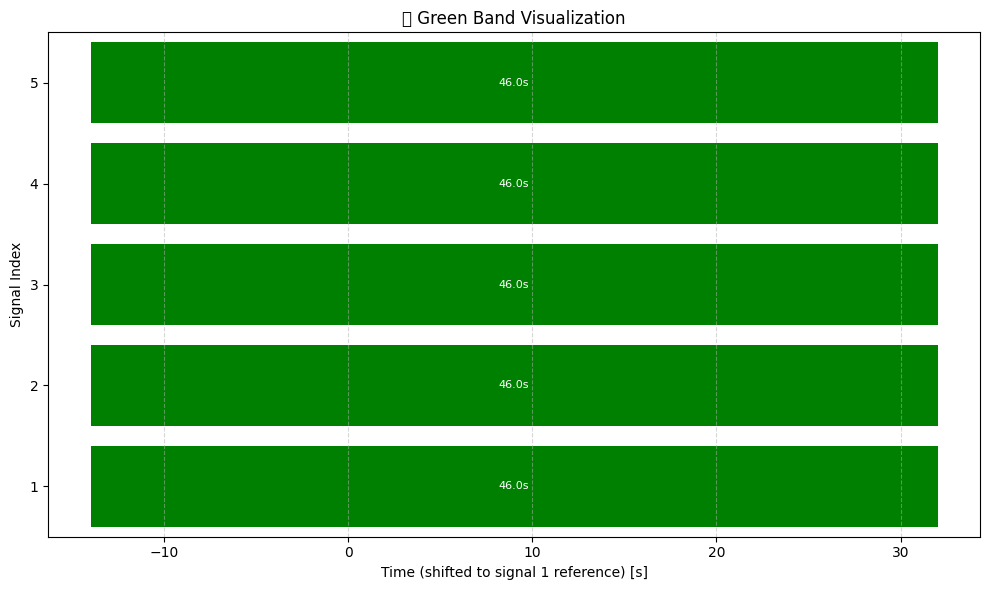

In [8]:
plot_green_bands(model, t)


In [9]:
from pyomo.environ import *

def build_bidirectional_corridor_model(n, C, t_outbound, t_inbound, g_min, g_max, M=1000):
    model = ConcreteModel()
    model.J = RangeSet(1, n)

    model.C = Param(initialize=C)
    model.t_out = Param(model.J, initialize=t_outbound)
    model.t_in = Param(model.J, initialize=t_inbound)
    model.g_min = Param(initialize=g_min)
    model.g_max = Param(initialize=g_max)
    model.M = Param(initialize=M)

    # OUTBOUND direction (1 → n)
    model.s = Var(model.J, bounds=(0, C))
    model.g = Var(model.J, bounds=(g_min, g_max))
    model.e = Var(model.J)
    model.x = Var(model.J, within=Binary)
    model.y = Var(model.J, within=Binary)
    model.early_end_out = Var()
    model.late_start_out = Var()
    model.o_out = Var(within=NonNegativeReals)

    # INBOUND direction (n → 1)
    model.s_rev = Var(model.J, bounds=(0, C))
    model.g_rev = Var(model.J, bounds=(g_min, g_max))
    model.e_rev = Var(model.J)
    model.x_rev = Var(model.J, within=Binary)
    model.y_rev = Var(model.J, within=Binary)
    model.early_end_in = Var()
    model.late_start_in = Var()
    model.o_in = Var(within=NonNegativeReals)

    ## --- OUTBOUND constraints ---
    def end_out_rule(m, j): return m.e[j] == m.s[j] + m.g[j]
    model.end_out = Constraint(model.J, rule=end_out_rule)

    def early_upper_out(m, j): return m.early_end_out <= m.e[j] - m.t_out[j]
    def early_lower_out(m, j): return m.early_end_out >= m.e[j] - m.t_out[j] - m.M * m.x[j]
    def late_lower_out(m, j): return m.late_start_out >= m.s[j] - m.t_out[j]
    def late_upper_out(m, j): return m.late_start_out <= m.s[j] - m.t_out[j] + m.M * m.y[j]

    model.early_upper_out = Constraint(model.J, rule=early_upper_out)
    model.early_lower_out = Constraint(model.J, rule=early_lower_out)
    model.late_lower_out = Constraint(model.J, rule=late_lower_out)
    model.late_upper_out = Constraint(model.J, rule=late_upper_out)

    model.min_selector_out = Constraint(expr=sum(model.x[j] for j in model.J) == n - 1)
    model.max_selector_out = Constraint(expr=sum(model.y[j] for j in model.J) == n - 1)
    model.overlap_out_def = Constraint(expr=model.o_out == model.early_end_out - model.late_start_out)
    model.overlap_out_pos = Constraint(expr=model.o_out >= 0)

    ## --- INBOUND constraints ---
    def end_in_rule(m, j): return m.e_rev[j] == m.s_rev[j] + m.g_rev[j]
    model.end_in = Constraint(model.J, rule=end_in_rule)

    def early_upper_in(m, j): return m.early_end_in <= m.e_rev[j] - m.t_in[j]
    def early_lower_in(m, j): return m.early_end_in >= m.e_rev[j] - m.t_in[j] - m.M * m.x_rev[j]
    def late_lower_in(m, j): return m.late_start_in >= m.s_rev[j] - m.t_in[j]
    def late_upper_in(m, j): return m.late_start_in <= m.s_rev[j] - m.t_in[j] + m.M * m.y_rev[j]

    model.early_upper_in = Constraint(model.J, rule=early_upper_in)
    model.early_lower_in = Constraint(model.J, rule=early_lower_in)
    model.late_lower_in = Constraint(model.J, rule=late_lower_in)
    model.late_upper_in = Constraint(model.J, rule=late_upper_in)

    model.min_selector_in = Constraint(expr=sum(model.x_rev[j] for j in model.J) == n - 1)
    model.max_selector_in = Constraint(expr=sum(model.y_rev[j] for j in model.J) == n - 1)
    model.overlap_in_def = Constraint(expr=model.o_in == model.early_end_in - model.late_start_in)
    model.overlap_in_pos = Constraint(expr=model.o_in >= 0)

    ## --- Objective ---
    model.obj = Objective(expr=model.o_out + model.o_in, sense=maximize)

    return model


In [10]:
# Number of signals
n = 5
C = 90
g_min = 10
g_max = 45

# Realistic fixed signal spacing (in meters)
positions = [0, 280, 610, 900, 1230]  # cumulative distances from signal 1
speed = 15  # m/s (≈ 54 km/h)

# Outbound: from signal 1 to others
t_out = {j + 1: (positions[j] - positions[0]) / speed for j in range(n)}

# Inbound: from signal n to others (reverse direction)
t_in = {j + 1: (positions[-1] - positions[j]) / speed for j in range(n)}

# Build and solve
model = build_bidirectional_corridor_model(n, C, t_out, t_in, g_min, g_max)

solver = SolverFactory("glpk", executable="/usr/bin/glpsol")  # adjust path as needed
solver.solve(model)

# Output results
print(f"\n🟢 Total overlap: Outbound = {value(model.o_out):.2f}, Inbound = {value(model.o_in):.2f}\n")




🟢 Total overlap: Outbound = 45.00, Inbound = 45.00



In [11]:
print("=== OUTBOUND ===")
for j in model.J:
    print(f"Signal {j}: s = {value(model.s[j]):.2f}, t = {t_out[j]:.2f}, shifted = {value(model.s[j]) - t_out[j]:.2f}")

print("\n=== INBOUND ===")
for j in model.J:
    print(f"Signal {j}: s_rev = {value(model.s_rev[j]):.2f}, t = {t_in[j]:.2f}, shifted = {value(model.s_rev[j]) - t_in[j]:.2f}")


=== OUTBOUND ===
Signal 1: s = 0.00, t = 0.00, shifted = 0.00
Signal 2: s = 18.67, t = 18.67, shifted = 0.00
Signal 3: s = 40.67, t = 40.67, shifted = 0.00
Signal 4: s = 60.00, t = 60.00, shifted = 0.00
Signal 5: s = 82.00, t = 82.00, shifted = 0.00

=== INBOUND ===
Signal 1: s_rev = 82.00, t = 82.00, shifted = 0.00
Signal 2: s_rev = 63.33, t = 63.33, shifted = -0.00
Signal 3: s_rev = 41.33, t = 41.33, shifted = -0.00
Signal 4: s_rev = 22.00, t = 22.00, shifted = 0.00
Signal 5: s_rev = 0.00, t = 0.00, shifted = 0.00


In [12]:
def plot_actual_green_bands_two_cycles(model):
    C = value(model.C)
    n = len(model.J)
    fig, ax = plt.subplots(figsize=(10, 10))

    for j in model.J:
        s_out = value(model.s[j])
        g_out = value(model.g[j])
        s_in = value(model.s_rev[j])
        g_in = value(model.g_rev[j])

        for cycle in [0, 1]:
            shift = cycle * C

            # Outbound (green) - signal's own time
            ax.broken_barh([(j - 0.35, 0.3)], (s_out + shift, g_out), facecolors='green')

            # Inbound (red) - signal's own time
            ax.broken_barh([(j + 0.05, 0.3)], (s_in + shift, g_in), facecolors='red')

    ax.set_ylabel("Time [s]")
    ax.set_xlabel("Signal Index")
    ax.set_title("🟢 Outbound & 🔴 Inbound Green Bands at Signal Controllers Over Two Cycles")
    ax.set_xticks(list(model.J))
    ax.set_xlim(0.5, n + 0.5)
    ax.set_ylim(0, 2 * C + 10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-12-544274376.py:28: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-544274376.py:28: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


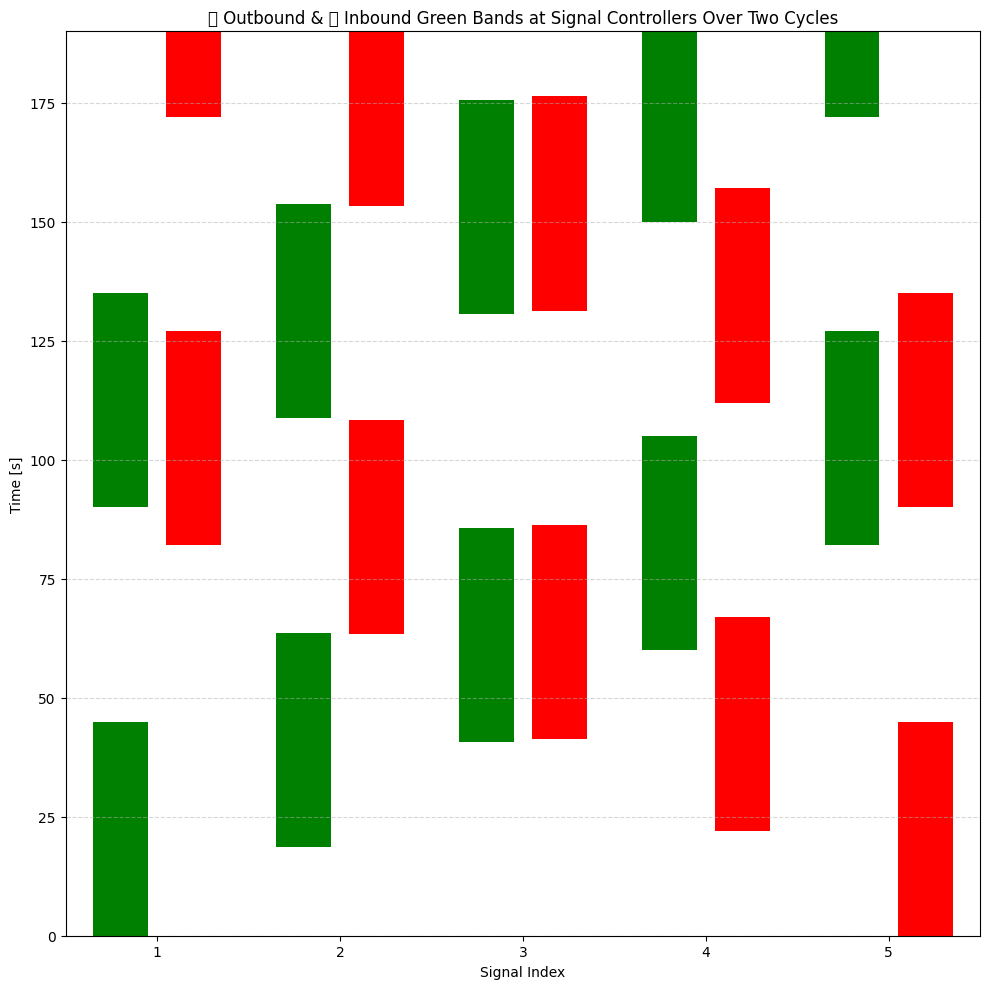

In [13]:
plot_actual_green_bands_two_cycles(model)


In [14]:
def plot_clean_side_by_side_green_bands(model):
    C = value(model.C)
    n = len(model.J)
    fig, ax = plt.subplots(figsize=(2.5 * n, 12))  # much bigger

    bar_width = 0.09
    bar_spacing = 0.02

    for j in model.J:
        s_out = [value(model.s[j]) + k * C for k in [0, 1]]
        g_out = [value(model.g[j])] * 2
        s_in = [value(model.s_rev[j]) + k * C for k in [0, 1]]
        g_in = [value(model.g_rev[j])] * 2

        x_green = j - bar_width / 2 - bar_spacing / 2
        x_red   = j + bar_spacing / 2

        for shift, g in zip(s_out, g_out):
            ax.broken_barh([(x_green, bar_width)], (shift, g), facecolors='green')

        for shift, g in zip(s_in, g_in):
            ax.broken_barh([(x_red, bar_width)], (shift, g), facecolors='red')

    ax.set_ylabel("Time [s]", fontsize=14)
    ax.set_xlabel("Signal Index", fontsize=14)
    ax.set_title("🟢 Outbound and 🔴 Inbound Green Bands per Signal (2 Cycles)", fontsize=16)
    ax.set_xticks(list(model.J))
    ax.set_xlim(0.5, n + 0.5)
    ax.set_ylim(0, 2 * C + 10)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-14-461212595.py:32: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-14-461212595.py:32: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


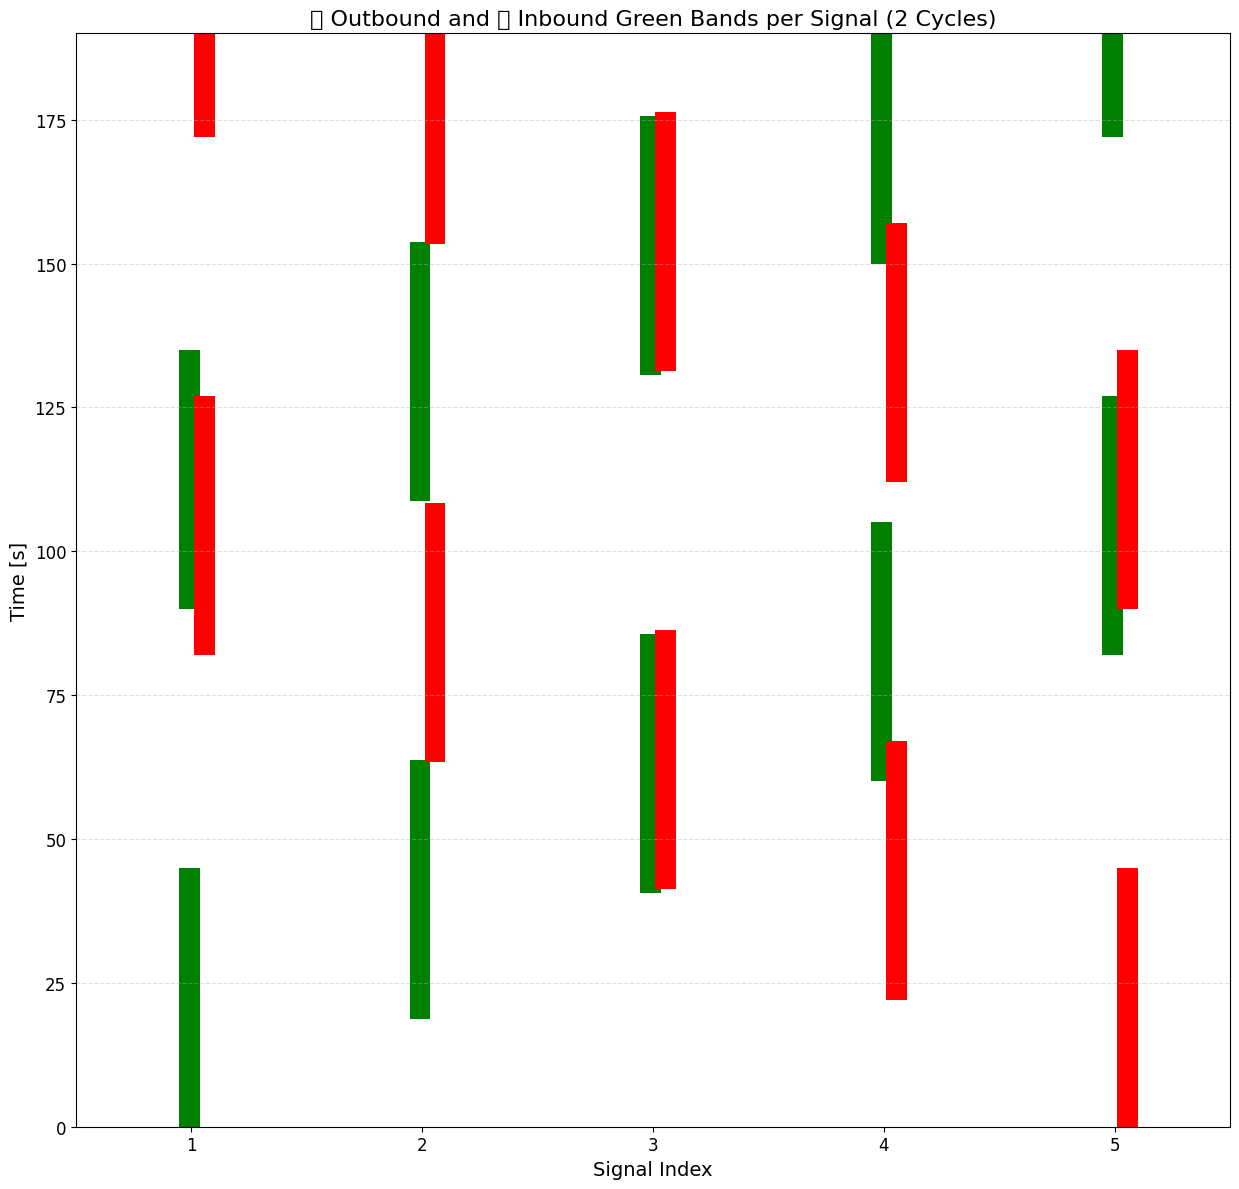

In [15]:
plot_clean_side_by_side_green_bands(model)


In [25]:
# code below calculates the white space in each intersection.
# next we want to see what happens if we want this white space not be smaller than a certain amount!!


def compute_non_coord_time_double_cycle(model):
    C = value(model.C)
    results = {}
    for j in model.J:
        intervals = []
        for k in [0, 1]:  # two cycles
            s_out_k = value(model.s[j]) + k * C
            e_out_k = s_out_k + value(model.g[j])
            intervals.append((s_out_k, e_out_k))

            s_in_k = value(model.s_rev[j]) + k * C
            e_in_k = s_in_k + value(model.g_rev[j])
            intervals.append((s_in_k, e_in_k))

        intervals.sort()
        merged = []
        for start, end in intervals:
            if not merged or start > merged[-1][1]:
                merged.append([start, end])
            else:
                merged[-1][1] = max(merged[-1][1], end)

        used_time = sum(end - start for start, end in merged)
        non_coord_time = 2 * C - used_time

        # Round to 1 decimal place
        merged_rounded = [[round(start, 1), round(end, 1)] for start, end in merged]
        results[j] = {
            "merged_intervals": merged_rounded,
            "used_time": round(used_time, 1),
            "non_coord_time": round(non_coord_time, 1)
        }

    return results


from pprint import pprint
pprint(compute_non_coord_time_double_cycle(model))


{1: {'merged_intervals': [[0.0, 45.0], [82.0, 135.0], [172.0, 217.0]],
     'non_coord_time': 37.0,
     'used_time': 143.0},
 2: {'merged_intervals': [[18.7, 108.3], [108.7, 198.3]],
     'non_coord_time': 0.7,
     'used_time': 179.3},
 3: {'merged_intervals': [[40.7, 86.3], [130.7, 176.3]],
     'non_coord_time': 88.7,
     'used_time': 91.3},
 4: {'merged_intervals': [[22.0, 105.0], [112.0, 195.0]],
     'non_coord_time': 14.0,
     'used_time': 166.0},
 5: {'merged_intervals': [[0.0, 45.0], [82.0, 135.0], [172.0, 217.0]],
     'non_coord_time': 37.0,
     'used_time': 143.0}}


In [26]:
from pyomo.environ import *

def build_bidirectional_corridor_model(n, C, t_outbound, t_inbound, g_min, g_max, non_coord_min, M=1000):
    model = ConcreteModel()
    model.J = RangeSet(1, n)

    # --- Parameters ---
    model.C = Param(initialize=C)
    model.t_out = Param(model.J, initialize=t_outbound)
    model.t_in = Param(model.J, initialize=t_inbound)
    model.g_min = Param(initialize=g_min)
    model.g_max = Param(initialize=g_max)
    model.M = Param(initialize=M)
    model.non_coord_min = Param(initialize=non_coord_min)

    # --- OUTBOUND variables (1 → n) ---
    model.s = Var(model.J, bounds=(0, C))                        # green start
    model.g = Var(model.J, bounds=(g_min, g_max))                # green duration
    model.e = Var(model.J)                                       # green end
    model.x = Var(model.J, within=Binary)                        # min selector
    model.y = Var(model.J, within=Binary)                        # max selector
    model.early_end_out = Var()
    model.late_start_out = Var()
    model.o_out = Var(within=NonNegativeReals)                  # overlap amount

    # --- INBOUND variables (n → 1) ---
    model.s_rev = Var(model.J, bounds=(0, C))
    model.g_rev = Var(model.J, bounds=(g_min, g_max))
    model.e_rev = Var(model.J)
    model.x_rev = Var(model.J, within=Binary)
    model.y_rev = Var(model.J, within=Binary)
    model.early_end_in = Var()
    model.late_start_in = Var()
    model.o_in = Var(within=NonNegativeReals)

    # --- NON-COORDINATED (white space) ---
    model.non_coord = Var(model.J, within=NonNegativeReals)

    # --- OUTBOUND constraints ---
    def end_out_rule(m, j): return m.e[j] == m.s[j] + m.g[j]
    model.end_out = Constraint(model.J, rule=end_out_rule)

    def early_upper_out(m, j): return m.early_end_out <= m.e[j] - m.t_out[j]
    def early_lower_out(m, j): return m.early_end_out >= m.e[j] - m.t_out[j] - m.M * m.x[j]
    def late_lower_out(m, j): return m.late_start_out >= m.s[j] - m.t_out[j]
    def late_upper_out(m, j): return m.late_start_out <= m.s[j] - m.t_out[j] + m.M * m.y[j]

    model.early_upper_out = Constraint(model.J, rule=early_upper_out)
    model.early_lower_out = Constraint(model.J, rule=early_lower_out)
    model.late_lower_out = Constraint(model.J, rule=late_lower_out)
    model.late_upper_out = Constraint(model.J, rule=late_upper_out)

    model.min_selector_out = Constraint(expr=sum(model.x[j] for j in model.J) == n - 1)
    model.max_selector_out = Constraint(expr=sum(model.y[j] for j in model.J) == n - 1)
    model.overlap_out_def = Constraint(expr=model.o_out == model.early_end_out - model.late_start_out)
    model.overlap_out_pos = Constraint(expr=model.o_out >= 0)

    # --- INBOUND constraints ---
    def end_in_rule(m, j): return m.e_rev[j] == m.s_rev[j] + m.g_rev[j]
    model.end_in = Constraint(model.J, rule=end_in_rule)

    def early_upper_in(m, j): return m.early_end_in <= m.e_rev[j] - m.t_in[j]
    def early_lower_in(m, j): return m.early_end_in >= m.e_rev[j] - m.t_in[j] - m.M * m.x_rev[j]
    def late_lower_in(m, j): return m.late_start_in >= m.s_rev[j] - m.t_in[j]
    def late_upper_in(m, j): return m.late_start_in <= m.s_rev[j] - m.t_in[j] + m.M * m.y_rev[j]

    model.early_upper_in = Constraint(model.J, rule=early_upper_in)
    model.early_lower_in = Constraint(model.J, rule=early_lower_in)
    model.late_lower_in = Constraint(model.J, rule=late_lower_in)
    model.late_upper_in = Constraint(model.J, rule=late_upper_in)

    model.min_selector_in = Constraint(expr=sum(model.x_rev[j] for j in model.J) == n - 1)
    model.max_selector_in = Constraint(expr=sum(model.y_rev[j] for j in model.J) == n - 1)
    model.overlap_in_def = Constraint(expr=model.o_in == model.early_end_in - model.late_start_in)
    model.overlap_in_pos = Constraint(expr=model.o_in >= 0)

    # --- WHITE SPACE constraints ---
    def non_coord_time_rule(m, j):
        return m.non_coord[j] == m.C - (m.g[j] + m.g_rev[j])
    model.non_coord_def = Constraint(model.J, rule=non_coord_time_rule)

    def non_coord_thresh_rule(m, j):
        return m.non_coord[j] >= m.non_coord_min
    model.non_coord_min_constraint = Constraint(model.J, rule=non_coord_thresh_rule)

    # --- Objective ---
    model.obj = Objective(expr=model.o_out + model.o_in, sense=maximize)

    return model


In [27]:
from pyomo.environ import *
from pprint import pprint

# === Corridor and Signal Parameters ===
n = 5
C = 90
g_min = 10
g_max = 45
non_coord_min = 25  # reserve at least 10s per signal for other phases

# === Signal spacing and speed ===
positions = [0, 280, 610, 900, 1230]  # meters
speed = 15  # m/s (≈ 54 km/h)

# === Travel times ===
t_out = {j + 1: (positions[j] - positions[0]) / speed for j in range(n)}
t_in = {j + 1: (positions[-1] - positions[j]) / speed for j in range(n)}

# === Model import ===
# Make sure the updated build_bidirectional_corridor_model function is already defined

# === Build and solve the model ===
model = build_bidirectional_corridor_model(
    n=n,
    C=C,
    t_outbound=t_out,
    t_inbound=t_in,
    g_min=g_min,
    g_max=g_max,
    non_coord_min=non_coord_min
)

solver = SolverFactory("glpk", executable="/usr/bin/glpsol")  # update path as needed
result = solver.solve(model, tee=True)

# === Output summary ===
print(f"\n🟢 Total Overlap:\n  Outbound = {value(model.o_out):.2f} s\n  Inbound  = {value(model.o_in):.2f} s\n")

print("⏳ Non-Coordinated Time per Signal:")
for j in model.J:
    print(f"  Signal {j}: {value(model.non_coord[j]):.1f} s")

print("\n🟢 Green Time Allocations:")
for j in model.J:
    print(f"  Signal {j}: Outbound g = {value(model.g[j]):.1f}, Inbound g = {value(model.g_rev[j]):.1f}")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpe1_75ncm.glpk.raw --wglp /tmp/tmpf8mx2x5t.glpk.glp --cpxlp
 /tmp/tmpa8zdh27w.pyomo.lp
Reading problem data from '/tmp/tmpa8zdh27w.pyomo.lp'...
/tmp/tmpa8zdh27w.pyomo.lp:455: warning: lower bound of variable 'x31' redefined
/tmp/tmpa8zdh27w.pyomo.lp:455: warning: upper bound of variable 'x31' redefined
68 rows, 61 columns, 178 non-zeros
20 integer variables, all of which are binary
475 lines were read
Writing problem data to '/tmp/tmpf8mx2x5t.glpk.glp'...
409 lines were written
GLPK Integer Optimizer 5.0
68 rows, 61 columns, 178 non-zeros
20 integer variables, all of which are binary
Preprocessing...
20 constraint coefficient(s) were reduced
61 rows, 54 columns, 164 non-zeros
20 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.350e+02  ratio =  1.350e+02
GM: min|aij| =  8.009e-01  max|aij| =  1.249e+00  ratio =  1.559e+00
EQ: min|aij| =  6.564e-01  ma

/tmp/ipython-input-14-461212595.py:32: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-14-461212595.py:32: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


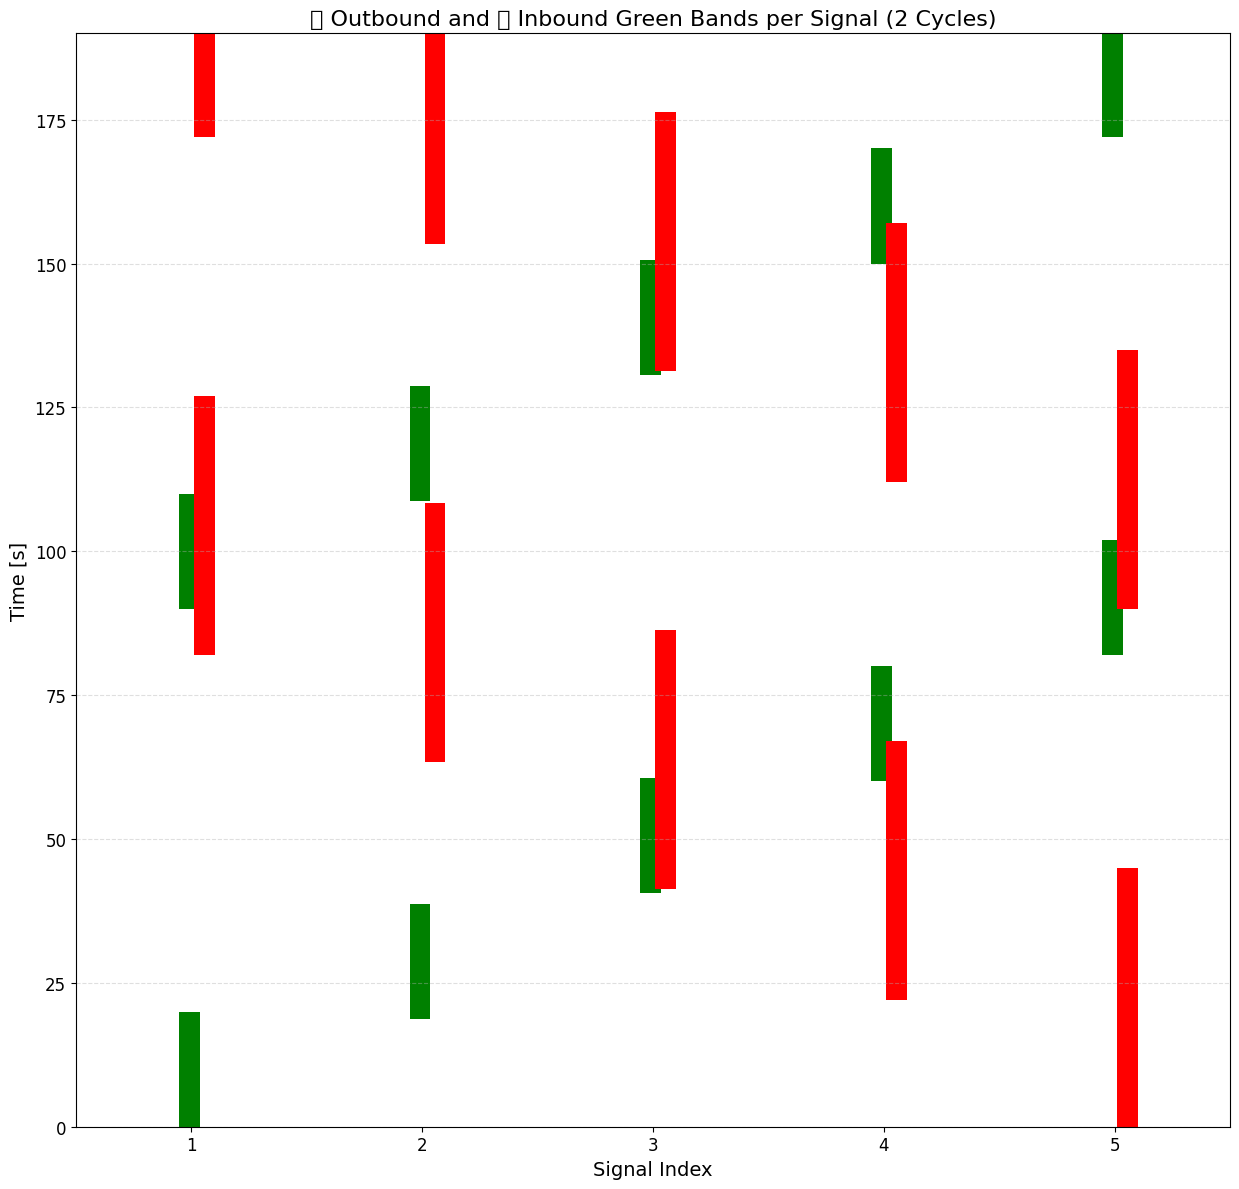

In [28]:
plot_clean_side_by_side_green_bands(model)
